## Логические методы классификации


### Цель работы

изучение принципов построения информационных систем с использованием логических методов классификации.

### Задачи 

 - освоение технологии внедрения алгоритмов на онове решающих списков в приложения;
 - освоение технологии внедрения алгоритмов на онове решающих деревьев в приложения;
 - изучение параметров логической классификации;
 - освоение модификаций логических методов классификации.

### Ход работы
#### 1 Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from matplotlib import pyplot as plt
%matplotlib inline

RANDOM_STATE=42

In [2]:
data_source = "./citrus.csv"
data = pd.read_csv(data_source, delimiter=',')
print(data.head(10))

     name  diameter  weight  red  green  blue
0  orange      2.96   86.76  172     85     2
1  orange      3.91   88.05  166     78     3
2  orange      4.42   95.17  156     81     2
3  orange      4.47   95.60  163     81     4
4  orange      4.48   95.76  161     72     9
5  orange      4.59   95.86  142    100     2
6  orange      4.64   97.94  156     85     2
7  orange      4.65   98.50  142     74     2
8  orange      4.68  100.20  159     90    16
9  orange      4.69  100.31  161     76     6


In [3]:
feats = ['diameter', 'weight', 'red', 'green', 'blue']
target = 'name'

for feat in feats:
    mean = data[feat].mean()
    data[feat].fillna(mean, inplace=True)
    
print(data[[*feats, target]].head(10))

X = data[feats]
Y = data[target]

   diameter  weight  red  green  blue    name
0      2.96   86.76  172     85     2  orange
1      3.91   88.05  166     78     3  orange
2      4.42   95.17  156     81     2  orange
3      4.47   95.60  163     81     4  orange
4      4.48   95.76  161     72     9  orange
5      4.59   95.86  142    100     2  orange
6      4.64   97.94  156     85     2  orange
7      4.65   98.50  142     74     2  orange
8      4.68  100.20  159     90    16  orange
9      4.69  100.31  161     76     6  orange


#### 2 Построение логического классификатора

##### 2.1 Построение модели с произвольными значениями максимальной глубины дерева и максимального количества признаков разделения дерева

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

decision_tree = DecisionTreeClassifier(
    max_depth=5,
    max_features=2,
    random_state=RANDOM_STATE,
)

decision_tree.fit(X_train, Y_train)
accur = accuracy_score(Y_train, decision_tree.predict(X_train))
print(accur)

0.9212857142857143


##### 2.2  Построение модели с оптимальными гиперпараметрами

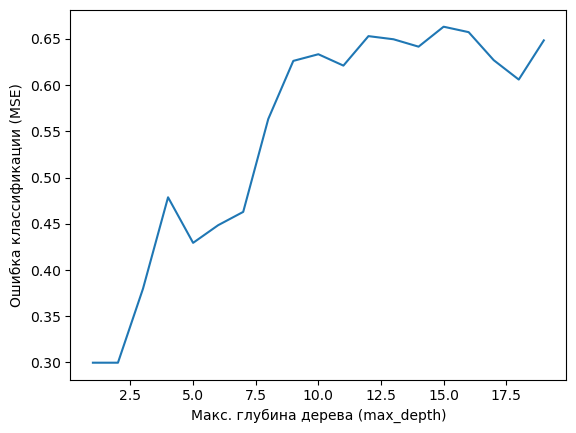

Оптимальные значения max_depth:  [1, 2]


In [5]:
cv_scores = []

depths=list(range(1, 20))

for depth in depths:
    decision_tree = DecisionTreeClassifier(
        max_depth=depth,
        max_features=2,
        random_state=RANDOM_STATE,
    )
    
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

plt.plot(depths, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

mse_min = min(MSE)

optimal_depths = []
for i in range(len(MSE)):
    if MSE[i] <= mse_min:
        optimal_depths.append(depths[i])

print('Оптимальные значения max_depth: ', optimal_depths)

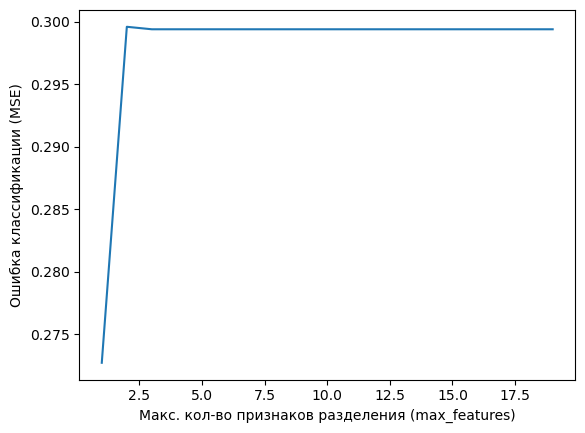

Оптимальные значения max_features:  [1]


In [6]:
cv_scores = []

max_features_counts=list(range(1, 20))

for max_features_count in max_features_counts:
    decision_tree = DecisionTreeClassifier(
        max_depth=optimal_depths[0],
        max_features=max_features_count,
        random_state=RANDOM_STATE,
    )
    
    scores = cross_val_score(decision_tree, X, Y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

plt.plot(depths, MSE)
plt.xlabel('Макс. кол-во признаков разделения (max_features)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

mse_min = min(MSE)

optimal_max_features_counts = []
for i in range(len(MSE)):
    if MSE[i] <= mse_min:
        optimal_max_features_counts.append(max_features_counts[i])

print('Оптимальные значения max_features: ', optimal_max_features_counts)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

decision_tree = DecisionTreeClassifier(
    max_depth=optimal_depths[0],
    max_features=optimal_max_features_counts[0],
    random_state=RANDOM_STATE,
)

decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=1, max_features=1, random_state=42)

In [8]:
feats_val = []
for feat in feats:
    val = float(input(f"Enter the {feat}: "))
    feats_val.append(val)
    
X_new = pd.DataFrame(np.array([feats_val]), columns=feats)
target = decision_tree.predict(X_new)

if target == 'orange':
    print('It is orange.')
elif target == 'grapefruit':
    print('It is grapefruit.')

Enter the diameter: 3.91
Enter the weight: 88.05
Enter the red: 166
Enter the green: 78
Enter the blue: 3
It is orange.


#### 3 Вывод оптимального дерева решений

In [17]:
decision_tree = DecisionTreeClassifier(
    max_depth=10, 
    random_state=RANDOM_STATE, 
    max_features=2
)

tree_params = { 
    'max_depth': range(1,20), 
    'max_features': range(1,4) 
}

tree_grid = GridSearchCV(
    decision_tree, 
    tree_params, 
    cv=10, 
    verbose=True,
    n_jobs=-1
)

tree_grid.fit(X, Y)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

optimal_tree = tree_grid.best_estimator_

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 5, 'max_features': 1}
Лучшие баллы cross validation:  0.7888999999999999


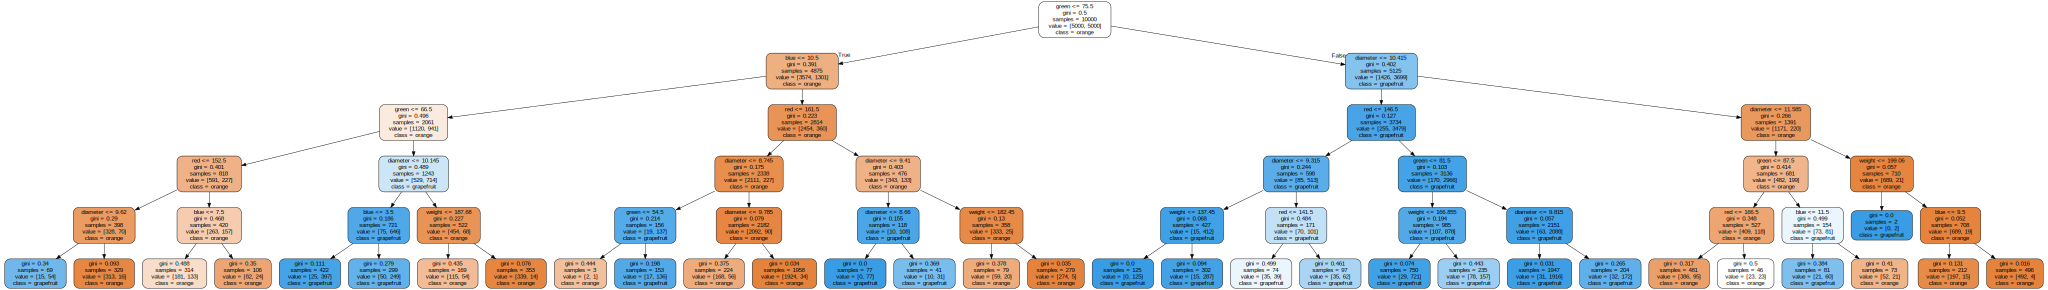

In [16]:
export_graphviz(
     optimal_tree, 
     feature_names=X.columns,
     class_names=Y.unique(),
     out_file='./tree.dot',  
     filled=True, 
     rounded=True
)

with open('./tree.dot') as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

#### 4 Вывод решающих границ

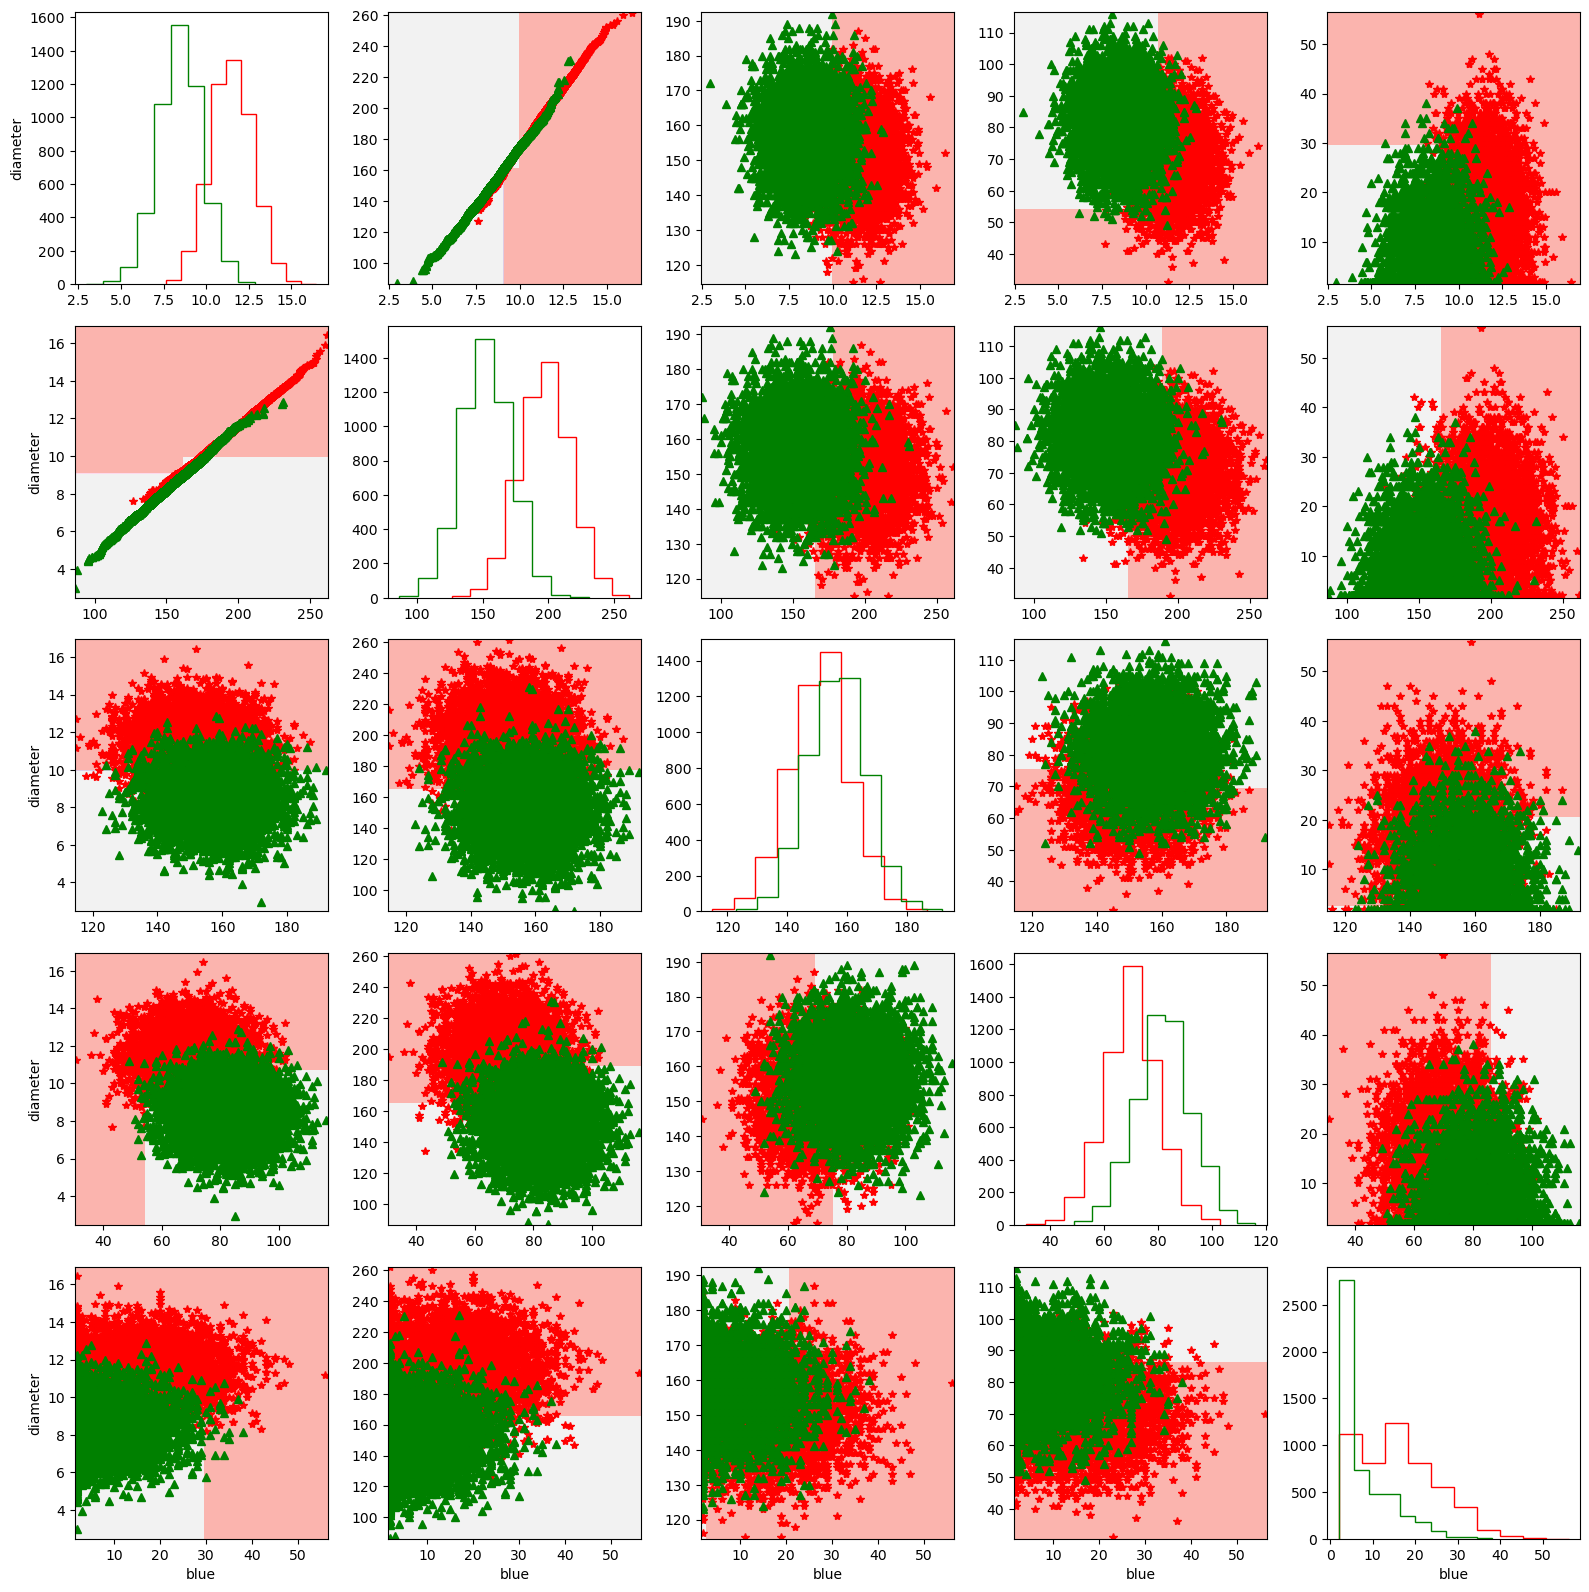

In [35]:
def visualize_decision_boundaries(X, y, plot_markers, figsize=(16, 16), max_depth=3):
    answers = np.unique(y)
    n_features = X.shape[1]

    f, places = plt.subplots(n_features, n_features, figsize=figsize)

    fmin = X.min() - 0.5
    fmax = X.max() + 0.5
    plot_step = 0.02

    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                xx, yy = np.meshgrid(
                    np.arange(fmin[i], fmax[i], plot_step),
                    np.arange(fmin[j], fmax[j], plot_step)
                )
                
                model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
                model.fit(X.iloc[:, [i, j]].values, y)
                
                p = model.predict(np.c_[xx.ravel(), yy.ravel()])
                p = p.reshape(xx.shape)
                
                for k in range(len(answers)):
                    p[p == answers[k]] = k
                    
                xx = xx.astype(np.float32)
                yy = yy.astype(np.float32)
                               
                p = p.astype(np.float32)
                places[i, j].contourf(xx, yy, p, cmap='Pastel1')

            for id_answer in range(len(answers)):
                idx = np.where(y == answers[id_answer])
                if i == j:                             
                    places[i, j].hist(
                        X.iloc[idx].iloc[:,i],
                        color=plot_markers[id_answer][0],
                        histtype = 'step'
                    )
                else:
                    places[i, j].plot(
                        X.iloc[idx].iloc[:,i],
                        X.iloc[idx].iloc[:,j], 
                        plot_markers[id_answer], 
                        label=answers[id_answer], 
                        markersize=6
                    )

            if j == 0:
                places[i, j].set_ylabel(X.columns[j])
            if i == n_features - 1:
                places[i, j].set_xlabel(X.columns[i])

    plt.tight_layout()
    plt.show()

visualize_decision_boundaries(X, Y, ['r*', 'g^', 'bo'])

### Контрольные вопросы

1. Поясните принцип построения дерева решений.

Дерево решений - это метод машинного обучения, который использует древовидную структуру для принятия решений. Основной принцип построения дерева решений заключается в разбиении данных на более мелкие подгруппы, исходя из признаков, с целью предсказания целевой переменной. Для каждого узла дерева выбирается признак, который наилучшим образом разделяет данные на две или более подгруппы. Этот процесс рекурсивно повторяется до тех пор, пока не будет выполнен критерий останова, такой как достижение определенной глубины дерева или недостаточного количества данных в узле. В листовых узлах дерева принимается решение или делается прогноз на основе большинства примеров в данной подгруппе.

2. Укажите статистическое определение информативности.

Информативность - это мера того, насколько хорошо определен признак разделяет данные на подгруппы. Она измеряется с использованием статистических метрик, таких как критерий Джини или энтропия. Чем ниже информативность, тем лучше признак разделяет данные.

3. Поясните энтропийное определение информативности.

Энтропия - это мера неопределенности в системе. В контексте деревьев решений, энтропия используется для измерения степени хаоса или разнообразия классов в узле. Более высокая энтропия означает большую неопределенность, а более низкая энтропия означает более однородные данные. При выборе признака для разделения данных в узле, мы стремимся минимизировать энтропию, чтобы улучшить информативность узла.

4. Что такое многоклассовая информативность? Для чего она применяется?

Многоклассовая информативность относится к случаям, когда целевая переменная имеет более двух классов. В этом случае используются меры информативности, такие как обобщенная энтропия или многоклассовый критерий Джини, чтобы оценить качество разделения данных по многим классам. Многоклассовая информативность используется в многоклассовой классификации для выбора наилучших признаков и разделения данных на подгруппы.

5. Поясните назначение и алгоритм бинаризации количественных признаков.

Бинаризация количественных признаков - это процесс преобразования числовых значений признаков в бинарные (да/нет) значения. Это необходимо для того, чтобы можно было использовать количественные признаки в дереве решений. Алгоритм бинаризации обычно заключается в выборе порогового значения и разделении данных на две категории: те, у которых значение признака меньше или равно пороговому значению, и те, у которых значение признака больше порога.

6. Поясните порядок поиска закономерностей в форме конъюнкций.

Поиск закономерностей в форме конъюнкций относится к процессу поиска правил или условий, которые состоят из комбинаций признаков и их значений. Эти правила определяют, какие действия следует предпринять или какие решения принимать на основе конкретных комбинаций признаков. В контексте деревьев решений, это означает определение, какие признаки и их значения должны быть учтены при разделении данных и принятии решений в каждом узле дерева.